In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/subs_data.csv')
print(sub.columns)
sub.describe(include='all')

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id'],
      dtype='object')


,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id
count,111668.000000,111668,111668,111668.000000,111668,111668.000000,111668.000000,111668.000000,111668,111668
unique,NaN,294,277,NaN,3,NaN,NaN,NaN,5,100000
top,NaN,2024-02-01,2024-11-01,NaN,monthly,NaN,NaN,NaN,PULSE,WFU2759137
freq,NaN,58654,43851,NaN,79219,NaN,NaN,NaN,50096,5
mean,118.185237,NaN,NaN,1.049002,NaN,29.065445,108.628462,0.040710,NaN,NaN
std,97.431236,NaN,NaN,0.267389,NaN,31.965700,31.421156,0.197618,NaN,NaN
min,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,1.000000,NaN,8.990000,86.880000,0.000000,NaN,NaN
50%,90.000000,NaN,NaN,1.000000,NaN,11.990000,107.880000,0.000000,NaN,NaN
75%,214.000000,NaN,NaN,1.000000,NaN,62.990000,131.880000,0.000000,NaN,NaN


In [3]:
demo = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/demo_data.csv')
print(demo.columns)
demo.describe(include='all')

Index(['Capstone_id', 'Age', 'Gender', 'Location', 'Email', 'Income'], dtype='object')


,Capstone_id,Age,Gender,Location,Email,Income
count,100000,100000.000000,100000,100000,100000,100000.000000
unique,100000,NaN,3,38190,85853,NaN
top,ETM3560501,NaN,Male,New Michael,nsmith@example.com,NaN
freq,1,NaN,49853,105,13,NaN
mean,NaN,54.412500,NaN,NaN,NaN,55449.838020
std,NaN,13.447178,NaN,NaN,NaN,22968.701534
min,NaN,18.000000,NaN,NaN,NaN,15000.000000
25%,NaN,45.000000,NaN,NaN,NaN,39235.750000
50%,NaN,55.000000,NaN,NaN,NaN,54155.000000
75%,NaN,64.000000,NaN,NaN,NaN,70101.000000


# Data Preprocessing
## Recalc
Recalc revenue within each term:
- `TERM_NUM`
- `REVENUE_RECALC`

In [4]:
# Calculate duration based on CURRENT_TERM
sub["TERM_NUM"] = sub.apply(
    lambda row: np.ceil(row["RECENCY"] / 30) if row["CURRENT_TERM"] == "monthly" else
                np.ceil(row["RECENCY"] / 7) if row["CURRENT_TERM"] == "weekly" else
                np.ceil(row["RECENCY"] / 365),  
    axis=1
)

# Compute REVENUE_RECALC
sub["REVENUE_RECALC"] = sub["TERM_NUM"] * sub["MONETARY"]
sub.head()

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,TERM_NUM,REVENUE_RECALC
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501,1.0,11.99
1,61,2024-09-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,PJW3033219,3.0,35.97
2,7,2024-11-01,2024-11-08,1,monthly,7.99,95.88,0,PULSE,DPZ5855080,1.0,7.99
3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372,2.0,23.98
4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438,5.0,59.95


## Cluster
Re-cluster revenue

In [5]:
def plot_sse_elbow(data, columns, k_range=range(1, 10), max_iter=1000):
    """
    Plots SSE for a range of cluster numbers to help determine the optimal number of clusters.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - k_range: range of cluster numbers to try (default is range(1, 10)).
    - max_iter: maximum number of iterations for the KMeans algorithm (default is 1000).
    """
    sse = {}
    X = data[[columns]]
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=max_iter)
        kmeans.fit(X)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Optimal k")
    plt.show()

In [6]:
def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

In [7]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

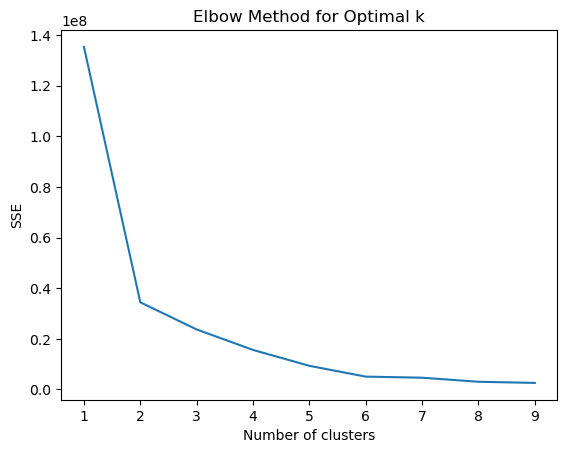

In [8]:
plot_sse_elbow(sub, 'REVENUE_RECALC')

In [9]:
sub = perform_kmeans(sub, 'REVENUE_RECALC', 3, 'REVENUE_RECALC_Cluster')
sub = order_cluster('REVENUE_RECALC_Cluster', 'REVENUE_RECALC', sub, True)
sub.groupby('REVENUE_RECALC_Cluster')['REVENUE_RECALC'].describe()

,count,mean,std,min,25%,50%,75%,max
REVENUE_RECALC_Cluster,,,,,,,,
0,47669.0,19.686419,9.144430,0.00,11.99,19.98,23.98,39.96
1,28449.0,63.397786,10.172763,43.96,53.94,62.99,72.99,77.94
2,35550.0,92.860641,21.277386,79.90,86.88,86.88,95.92,1003.00


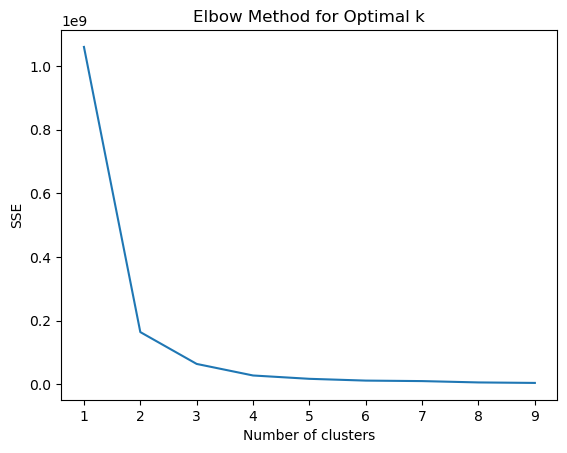

In [10]:
plot_sse_elbow(sub, 'RECENCY')

In [11]:
sub = perform_kmeans(sub, 'RECENCY', 3, 'RECENCY_Cluster')
sub = order_cluster('RECENCY_Cluster', 'RECENCY', sub, True)
sub.groupby('RECENCY_Cluster')['RECENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
RECENCY_Cluster,,,,,,,,
0,54044.0,31.503590,15.152983,1.0,30.0,32.0,32.0,80.0
1,24542.0,129.531660,31.664458,81.0,106.0,123.0,157.0,190.0
2,33082.0,251.374252,28.537356,191.0,214.0,274.0,274.0,304.0


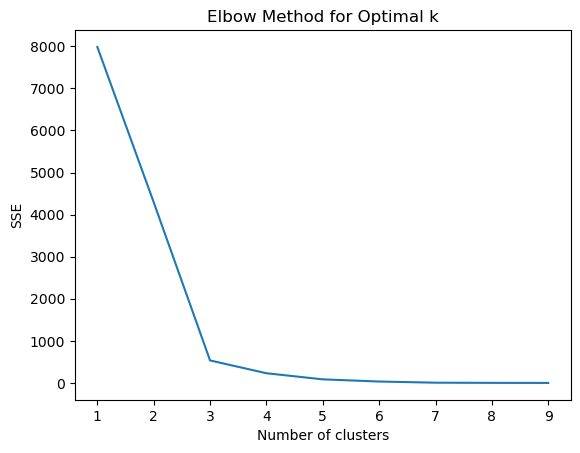

In [12]:
plot_sse_elbow(sub, 'FREQUENCY')

In [13]:
# sub["FREQUENCYCLUSTER"] = sub["FREQUENCYCLUSTER"].replace({2: 0, 1: 2, 0: 1})
sub = perform_kmeans(sub, 'FREQUENCY', 3, 'FREQUENCY_Cluster')
sub = order_cluster('FREQUENCY_Cluster', 'FREQUENCY', sub, False)
sub.groupby('FREQUENCY_Cluster')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
FREQUENCY_Cluster,,,,,,,,
0,650.0,3.424615,0.90777,3.0,3.0,3.0,4.0,10.0
1,3896.0,2.000000,0.00000,2.0,2.0,2.0,2.0,2.0
2,107122.0,1.000000,0.00000,1.0,1.0,1.0,1.0,1.0


## Segment
Combine cluster number info, split into low/mid/high segments

In [14]:
sub['Score'] = 0.3*sub['RECENCY_Cluster'] + 0.2*sub['FREQUENCY_Cluster'] + 0.5*sub['REVENUE_RECALC_Cluster'] 
sub.groupby('Score').agg({'RECENCY':'mean', 'FREQUENCY':'mean','REVENUE_RECALC':'mean'})

,RECENCY,FREQUENCY,REVENUE_RECALC
Score,,,
0.0,51.680851,3.042553,19.956170
0.2,38.974755,2.000000,18.233548
0.3,107.282609,3.347826,35.329565
0.4,31.234641,1.000000,17.654919
0.5,102.289809,2.009554,34.996561
0.6,253.000000,3.000000,8.990000
0.7,101.801105,1.006662,34.449480
0.8,156.789474,3.201754,55.310351
0.9,32.300360,1.000000,68.032469


In [15]:
print(sub.groupby('Score')['RECENCY'].count())

Score
0.0       47
0.2      713
0.3       46
0.4    39780
0.5      314
0.6        1
0.7     6154
0.8      114
0.9     6935
1.0     1349
1.1      123
1.2    13226
1.3      548
1.4     6501
1.5     6859
1.6      311
1.7     3998
1.8     1511
2.0    23138
Name: RECENCY, dtype: int64


In [16]:
sub.shape[0]/3

37222.666666666664

In [17]:
sub['Segment'] = 'Mid-Value'
sub.loc[sub['Score'] < 0.5, 'Segment'] = 'Low-Value' 
sub.loc[sub['Score'] > 1.4, 'Segment'] = 'High-Value' 

In [18]:
sub_low = sub[sub['Segment']=='Low-Value']
sub_mid = sub[sub['Segment']=='Mid-Value']
sub_high = sub[sub['Segment']=='High-Value']
print(sub_low.shape[0], sub_mid.shape[0], sub_high.shape[0])

40586 35265 35817


In [19]:
sub_low.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_low.csv')
sub_mid.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_mid.csv')
sub_high.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_high.csv')
sub.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_preprocessed.csv')

## Merge
Merge demographic data with each bucket

In [ ]:
sub_low_demo = sub_low.merge(demo, how='inner', on='Capstone_id')
sub_mid_demo = sub_mid.merge(demo, how='inner', on='Capstone_id')
sub_high_demo = sub_high.merge(demo, how='inner', on='Capstone_id')

In [ ]:
print(demo.Capstone_id.isin(sub_low.Capstone_id).sum(),
demo.Capstone_id.isin(sub_mid.Capstone_id).sum(),
demo.Capstone_id.isin(sub_high.Capstone_id).sum())

38587 10545 55122


In [ ]:
print(sub_low_demo.shape, sub_mid_demo.shape, sub_high_demo.shape)

(40819, 22) (10663, 22) (60186, 22)


In [ ]:
full = pd.concat([sub_low_demo, sub_mid_demo, sub_high_demo], ignore_index=True)
full.shape

(111668, 22)

In [ ]:
full.columns

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'TERM_NUM', 'REVENUE_RECALC', 'REVENUE_RECALC_Cluster',
       'RECENCY_Cluster', 'FREQUENCY_Cluster', 'Score', 'Segment', 'Age',
       'Gender', 'Location', 'Email', 'Income'],
      dtype='object')

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/2833020596.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/2833020596.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




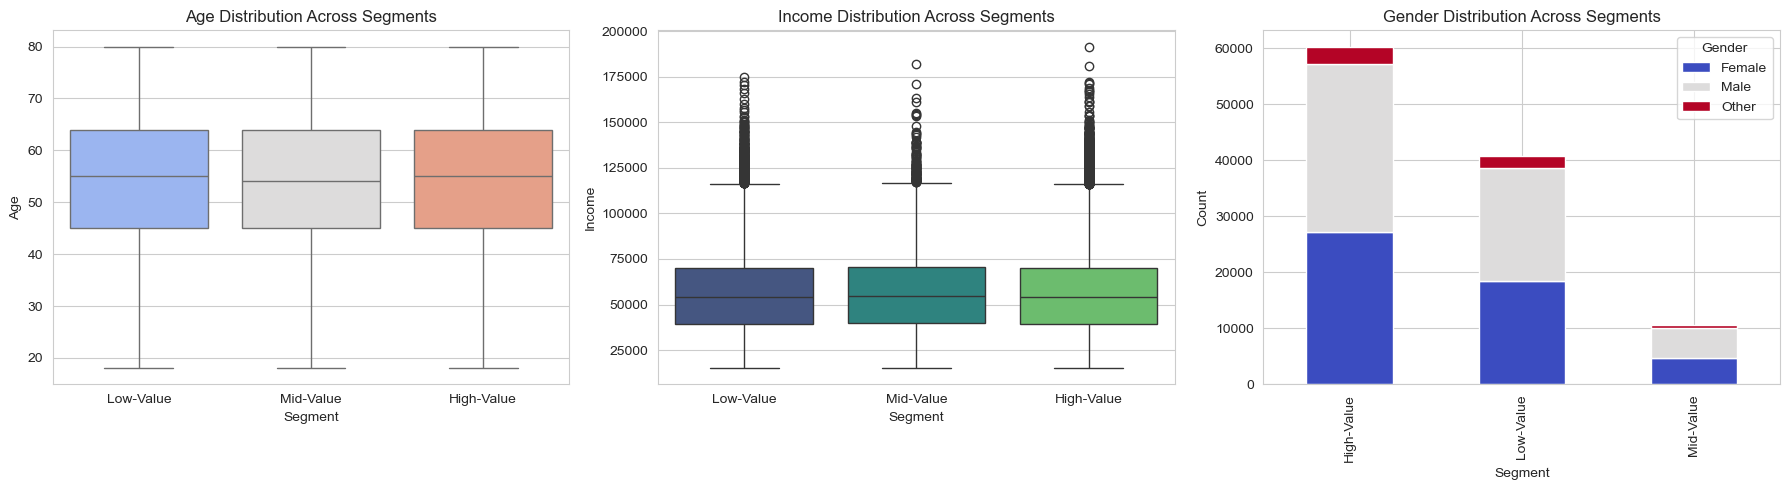

In [ ]:
# Set style for plots
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age Distribution (Histogram)
sns.boxplot(x="Segment", y="Age", data=full, palette="coolwarm", ax=axes[0])
axes[0].set_title("Age Distribution Across Segments")
axes[0].set_xlabel("Segment")
axes[0].set_ylabel("Age")

# Income Distribution (Histogram)
sns.boxplot(x="Segment", y="Income", data=full, palette="viridis", ax=axes[1])
axes[1].set_title("Income Distribution Across Segments")
axes[1].set_xlabel("Segment")
axes[1].set_ylabel("Income")

# Gender Distribution (Bar Plot)
gender_counts = full.groupby(["Segment", "Gender"]).size().unstack()
gender_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=axes[2])
axes[2].set_title("Gender Distribution Across Segments")
axes[2].set_xlabel("Segment")
axes[2].set_ylabel("Count")
axes[2].legend(title="Gender")

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
sub_low_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_low.csv')
sub_mid_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_mid.csv')
sub_high_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_high.csv')
full.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_full.csv')

In [ ]:
eda_low = {
    "Total Low-Value Customers": len(sub_low_demo),
    "Unique Brands": sub_low_demo["BRAND"].nunique(),
    "Subscription Terms": sub_low_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_low_demo["RECENCY"].mean(),
    "Average Frequency": sub_low_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_low_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_low_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_low_demo["Age"].describe(),
    "Income Distribution": sub_low_demo["Income"].describe(),
    "Gender Distribution": sub_low_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_low_demo["Location"].value_counts().head(5).to_dict(),
}
eda_low

{'Total Low-Value Customers': 40819,
 'Unique Brands': 5,
 'Subscription Terms': {'monthly': 40197, 'annual': 622},
 'Average Recency': 31.85447953159068,
 'Average Frequency': 1.0280261642862392,
 'Average Monetary Value': 17.776742693353587,
 'Resubscriber Rate': 0.025453832773953307,
 'Age Distribution': count    40819.000000
 mean        54.405056
 std         13.444562
 min         18.000000
 25%         45.000000
 50%         55.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     40819.000000
 mean      55425.941694
 std       22899.732335
 min       15000.000000
 25%       39185.500000
 50%       54134.000000
 75%       70061.500000
 max      174998.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.4967539626154487,
  'Female': 0.4510889536735344,
  'Other': 0.052157083711016926},
 'Location Breakdown': {'New Michael': 53,
  'Port Michael': 36,
  'North John': 35,
  'South James': 34,
  'South 

In [ ]:
eda_mid = {
    "Total Low-Value Customers": len(sub_mid_demo),
    "Unique Brands": sub_mid_demo["BRAND"].nunique(),
    "Subscription Terms": sub_mid_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_mid_demo["RECENCY"].mean(),
    "Average Frequency": sub_mid_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_mid_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_mid_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_mid_demo["Age"].describe(),
    "Income Distribution": sub_mid_demo["Income"].describe(),
    "Gender Distribution": sub_mid_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_mid_demo["Location"].value_counts().head(5).to_dict(),
}
eda_mid

{'Total Low-Value Customers': 10663,
 'Unique Brands': 5,
 'Subscription Terms': {'annual': 5673, 'monthly': 4990},
 'Average Recency': 83.54890743693144,
 'Average Frequency': 1.1259495451561474,
 'Average Monetary Value': 47.14212416768265,
 'Resubscriber Rate': 0.0955641001594298,
 'Age Distribution': count    10663.000000
 mean        54.392291
 std         13.406855
 min         18.000000
 25%         45.000000
 50%         54.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     10663.000000
 mean      55777.680859
 std       23047.339650
 min       15000.000000
 25%       39689.500000
 50%       54525.000000
 75%       70591.500000
 max      181940.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.5067992122292038,
  'Female': 0.44274594391822186,
  'Other': 0.05045484385257432},
 'Location Breakdown': {'Port Michael': 14,
  'West Michael': 13,
  'North Michael': 13,
  'Lake Michael': 12,
  'Sout

In [ ]:
eda_high = {
    "Total Low-Value Customers": len(sub_high_demo),
    "Unique Brands": sub_high_demo["BRAND"].nunique(),
    "Subscription Terms": sub_high_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_high_demo["RECENCY"].mean(),
    "Average Frequency": sub_high_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_high_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_high_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_high_demo["Age"].describe(),
    "Income Distribution": sub_high_demo["Income"].describe(),
    "Gender Distribution": sub_high_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_high_demo["Location"].value_counts().head(5).to_dict(),
}
eda_high

{'Total Low-Value Customers': 60186,
 'Unique Brands': 5,
 'Subscription Terms': {'monthly': 34032, 'annual': 26153, 'weekly': 1},
 'Average Recency': 182.87241218888113,
 'Average Frequency': 1.0495962516199782,
 'Average Monetary Value': 80.00076363273851,
 'Resubscriber Rate': 0.0413385172631509,
 'Age Distribution': count    60186.000000
 mean        54.406207
 std         13.431112
 min         18.000000
 25%         45.000000
 50%         55.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     60186.000000
 mean      55409.187020
 std       23021.591775
 min       15000.000000
 25%       39212.250000
 50%       54051.500000
 75%       69974.500000
 max      191510.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.49916924201641577,
  'Female': 0.4513175821619646,
  'Other': 0.04951317582161965},
 'Location Breakdown': {'New Michael': 60,
  'West Michael': 54,
  'North Michael': 51,
  'Port Michae

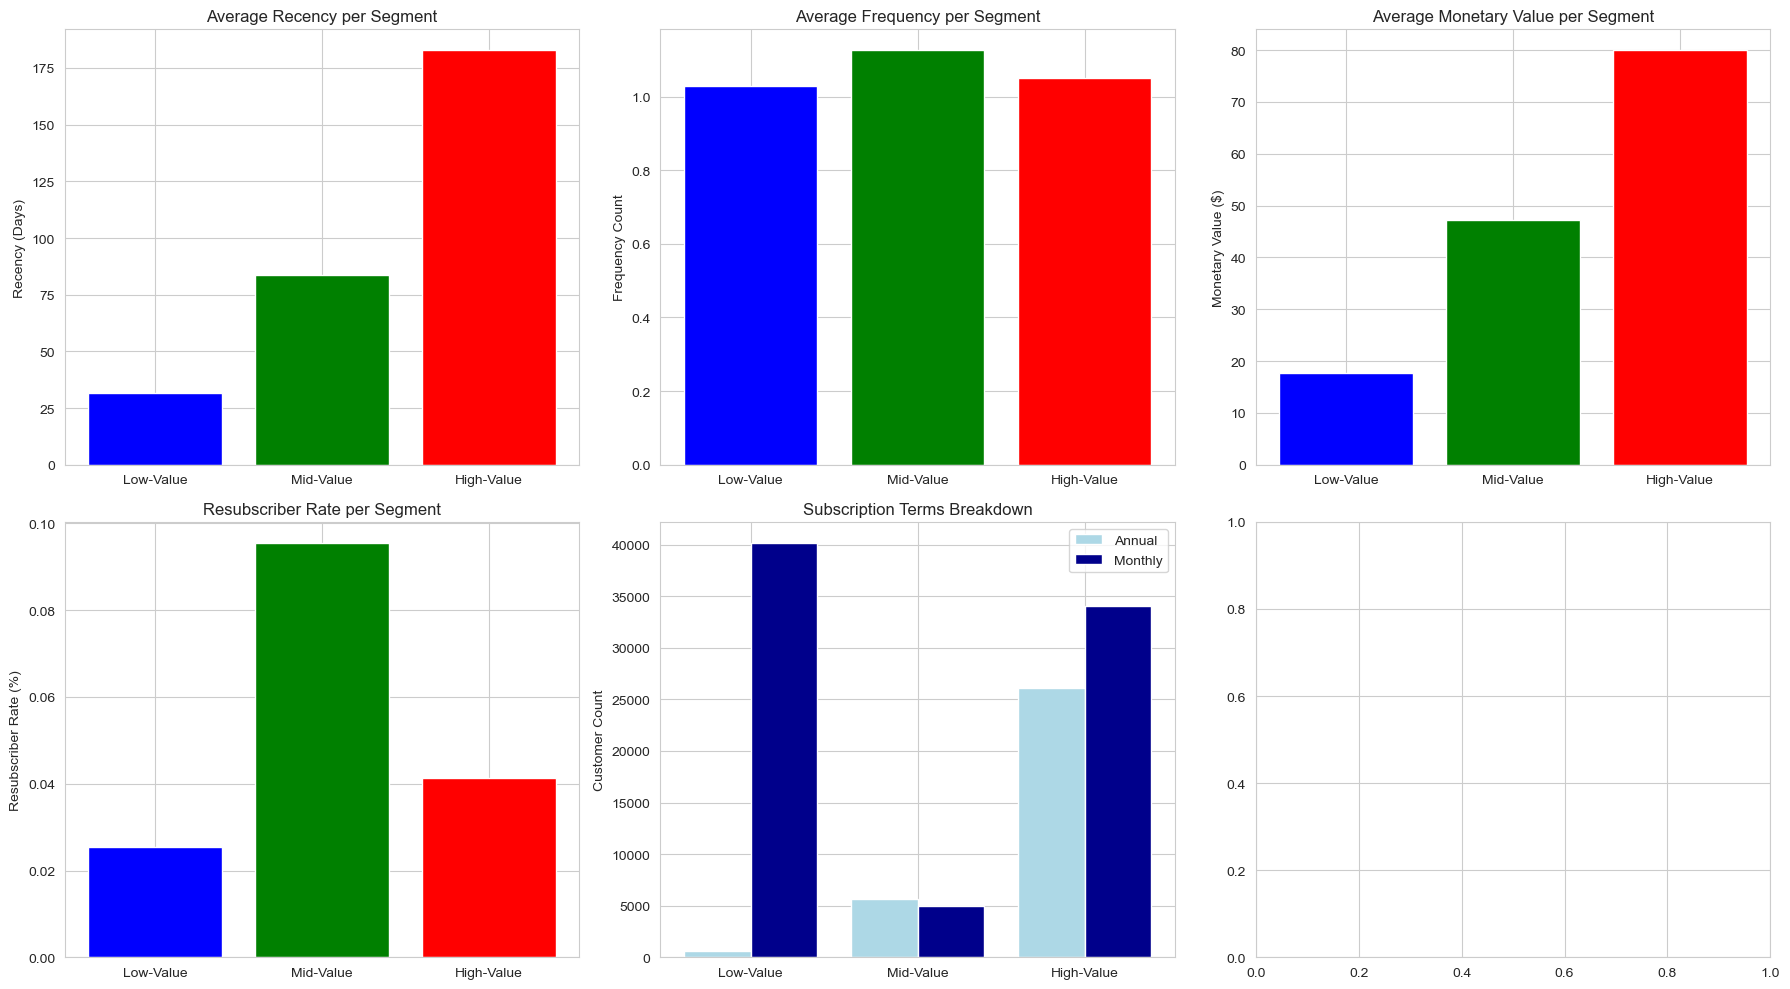

In [ ]:
# Extract values for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]
avg_revenue = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]
avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]
avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]
resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Extract key metrics for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Data to be visualized
avg_recency = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]

avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]

avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]

resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]

# Subscription Terms Breakdown
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Average Recency
axes[0, 0].bar(segments, avg_recency, color=['blue', 'green', 'red'])
axes[0, 0].set_title("Average Recency per Segment")
axes[0, 0].set_ylabel("Recency (Days)")

# Plot Average Frequency
axes[0, 1].bar(segments, avg_frequency, color=['blue', 'green', 'red'])
axes[0, 1].set_title("Average Frequency per Segment")
axes[0, 1].set_ylabel("Frequency Count")

# Plot Average Monetary Value
axes[0, 2].bar(segments, avg_monetary, color=['blue', 'green', 'red'])
axes[0, 2].set_title("Average Monetary Value per Segment")
axes[0, 2].set_ylabel("Monetary Value ($)")

# Plot Resubscriber Rate
axes[1, 0].bar(segments, resubscriber_rate, color=['blue', 'green', 'red'])
axes[1, 0].set_title("Resubscriber Rate per Segment")
axes[1, 0].set_ylabel("Resubscriber Rate (%)")

# Plot Subscription Term Distribution
x = np.arange(len(segments))
width = 0.4

axes[1, 1].bar(x - width/2, subscription_terms["Annual"], width, label='Annual', color='lightblue')
axes[1, 1].bar(x + width/2, subscription_terms["Monthly"], width, label='Monthly', color='darkblue')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(segments)
axes[1, 1].set_title("Subscription Terms Breakdown")
axes[1, 1].set_ylabel("Customer Count")
axes[1, 1].legend()

# Display plots
plt.tight_layout()
plt.show()

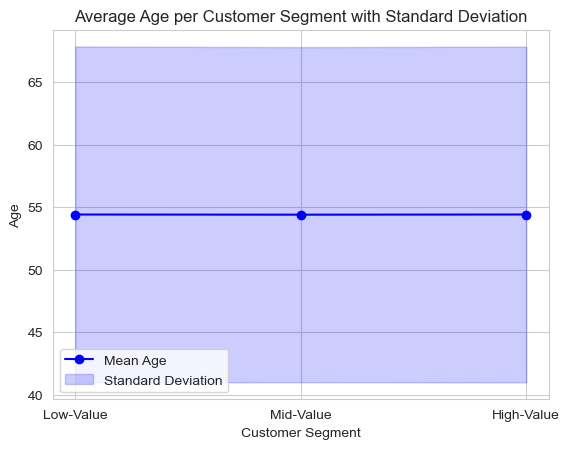

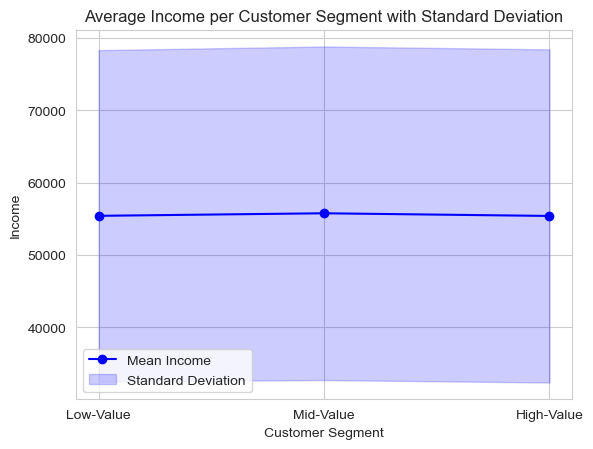

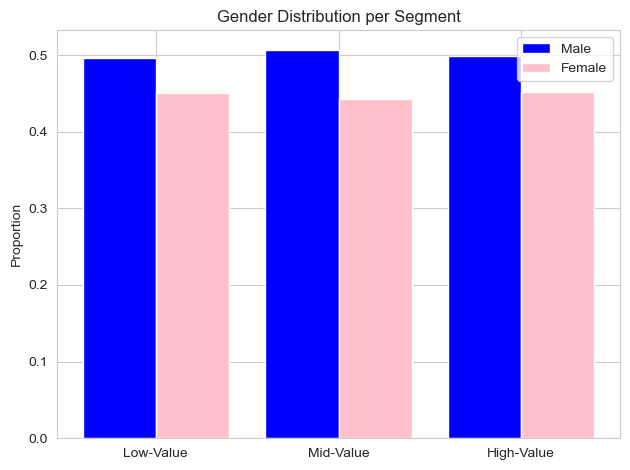

In [ ]:
# Extracting relevant data from the summary dictionaries
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Age statistics
age_mean = [
    eda_low["Age Distribution"]["mean"],
    eda_mid["Age Distribution"]["mean"],
    eda_high["Age Distribution"]["mean"]
]

age_std = [
    eda_low["Age Distribution"]["std"],
    eda_mid["Age Distribution"]["std"],
    eda_high["Age Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, age_mean, marker='o', linestyle='-', color='blue', label="Mean Age")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(age_mean) - np.array(age_std), np.array(age_mean) + np.array(age_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Age")
plt.title("Average Age per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Income statistics
income_mean = [
    eda_low["Income Distribution"]["mean"],
    eda_mid["Income Distribution"]["mean"],
    eda_high["Income Distribution"]["mean"]
]

income_std = [
    eda_low["Income Distribution"]["std"],
    eda_mid["Income Distribution"]["std"],
    eda_high["Income Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, income_mean, marker='o', linestyle='-', color='blue', label="Mean Income")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(income_mean) - np.array(income_std), np.array(income_mean) + np.array(income_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Income")
plt.title("Average Income per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Gender distribution
gender_male = [
    eda_low["Gender Distribution"].get("Male", 0),
    eda_mid["Gender Distribution"].get("Male", 0),
    eda_high["Gender Distribution"].get("Male", 0)
]

gender_female = [
    eda_low["Gender Distribution"].get("Female", 0),
    eda_mid["Gender Distribution"].get("Female", 0),
    eda_high["Gender Distribution"].get("Female", 0)
]

plt.bar(x - width / 2, gender_male, width, label='Male', color='blue')
plt.bar(x + width / 2, gender_female, width, label='Female', color='pink')
plt.xticks(x, labels=segments)
plt.title("Gender Distribution per Segment")
plt.ylabel("Proportion")
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


# Sub Stats

In [ ]:
sub.columns

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'TERM_NUM', 'REVENUE_RECALC', 'REVENUE_RECALC_Cluster',
       'RECENCY_Cluster', 'FREQUENCY_Cluster', 'Score', 'Segment'],
      dtype='object')

## Summary: RFM, Resub

In [ ]:
# Grouping data by 'Segment' and calculating key statistics
segment_summary = sub.groupby("Segment").agg({
    "RECENCY": ["mean", "median"],
    "FREQUENCY": ["mean", "median"],
    "REVENUE_RECALC": ["mean", "sum"],
    "RESUBSCRIBER": ["mean"]
}).round(2)
segment_summary

RECENCY        FREQUENCY        REVENUE_RECALC              \
              mean median      mean median           mean         sum   
Segment                                                                 
High-Value  182.87  213.0      1.05    1.0          80.00  4814925.96   
Low-Value    31.85   32.0      1.03    1.0          17.78   725628.86   
Mid-Value    83.55   84.0      1.13    1.0          47.14   502676.47   

           RESUBSCRIBER  
                   mean  
Segment                  
High-Value         0.04  
Low-Value          0.03  
Mid-Value          0.10

## Distribution across segment
### Revenue boxplot

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/4273420844.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




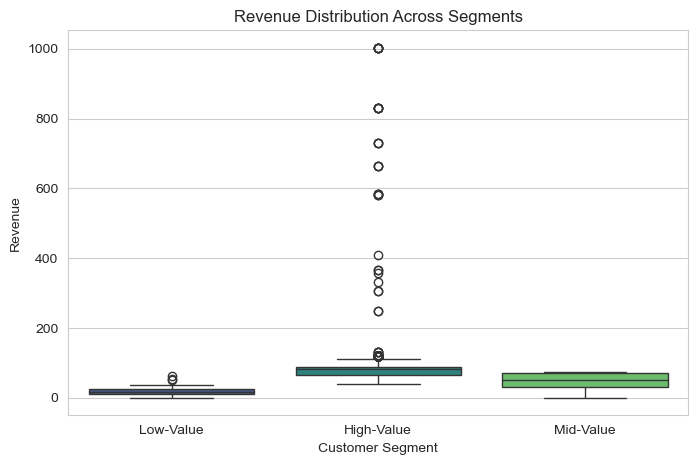

In [ ]:
# Boxplot for Revenue by Segment
plt.figure(figsize=(8,5))
sns.boxplot(x="Segment", y="REVENUE_RECALC", data=sub, palette="viridis")
plt.title("Revenue Distribution Across Segments")
plt.xlabel("Customer Segment")
plt.ylabel("Revenue")
plt.show()

### Sub term distribution

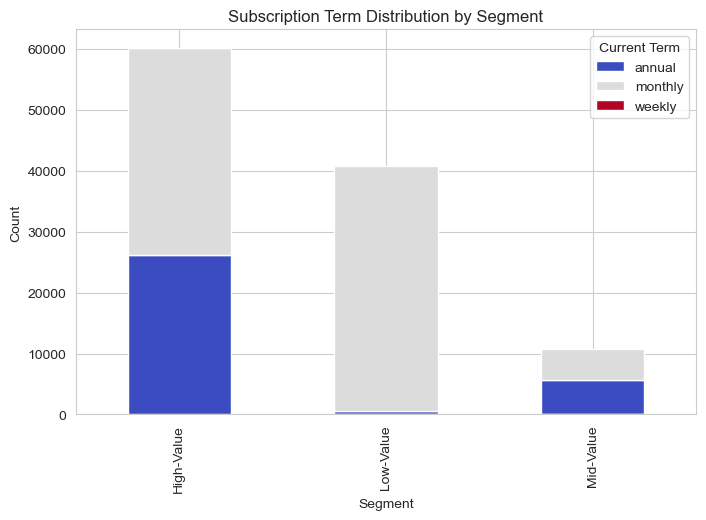

In [ ]:
# Count of subscription terms by segment
term_counts = sub.groupby(["Segment", "CURRENT_TERM"]).size().unstack()

# Plot distribution of subscription terms across segments
term_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Subscription Term Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Current Term")
plt.show()

In [ ]:
# Calculate the percentage of annual/monthly subscriptions within each segment
term_counts_percentage = term_counts.div(term_counts.sum(axis=1), axis=0) * 100
term_counts_percentage

CURRENT_TERM,annual,monthly,weekly
Segment,,,
High-Value,43.453627,56.544711,0.001662
Low-Value,1.523800,98.476200,NaN
Mid-Value,53.202663,46.797337,NaN


### Recency & Freq

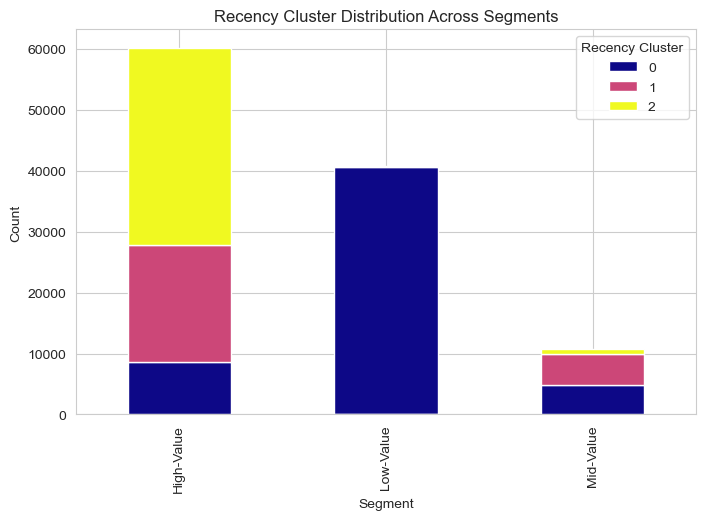

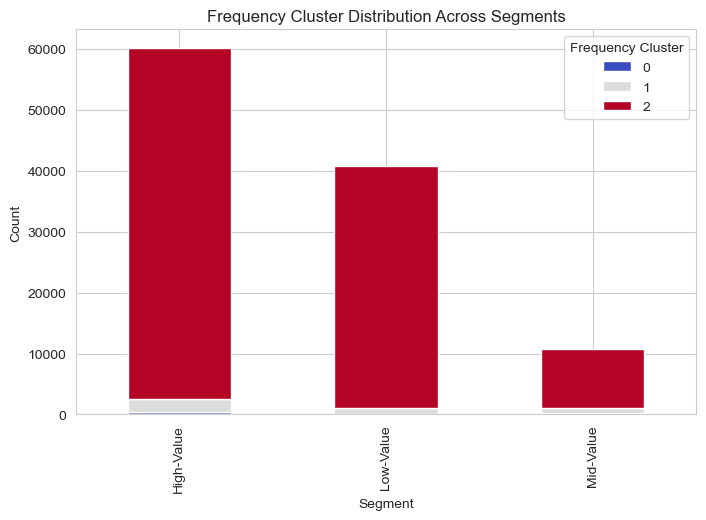

In [ ]:
# Count distribution of Recency and Frequency Clusters
recency_cluster_counts = sub.groupby("Segment")["RECENCY_Cluster"].value_counts().unstack()
frequency_cluster_counts = sub.groupby("Segment")["FREQUENCY_Cluster"].value_counts().unstack()

# Plot Recency Cluster Distribution
recency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="plasma")
plt.title("Recency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Recency Cluster")
plt.show()

# Plot Frequency Cluster Distribution
frequency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Frequency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Frequency Cluster")
plt.show()


# Demo Stats

In [ ]:
demo.columns

Index(['Capstone_id', 'Age', 'Gender', 'Location', 'Email', 'Income'], dtype='object')

## Age

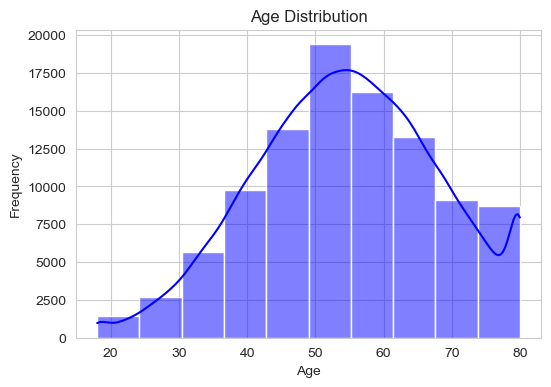

In [ ]:
# Age Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Age"], bins=10, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

## Gender

In [ ]:
# Gender Distribution
gender_counts = demo["Gender"].value_counts()
gender_counts

Gender
Male      49853
Female    45078
Other      5069
Name: count, dtype: int64

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/1507335075.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




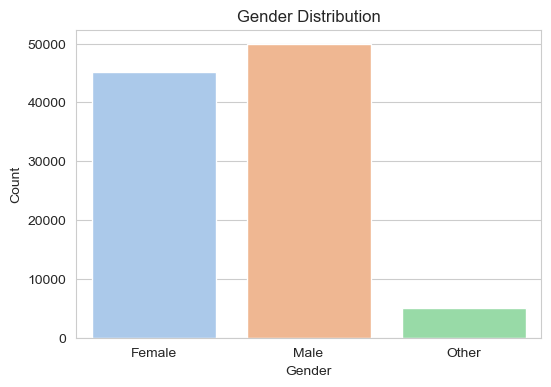

In [ ]:
# Gender Count Plot
plt.figure(figsize=(6,4))
sns.countplot(x=demo["Gender"], palette="pastel")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

## Income

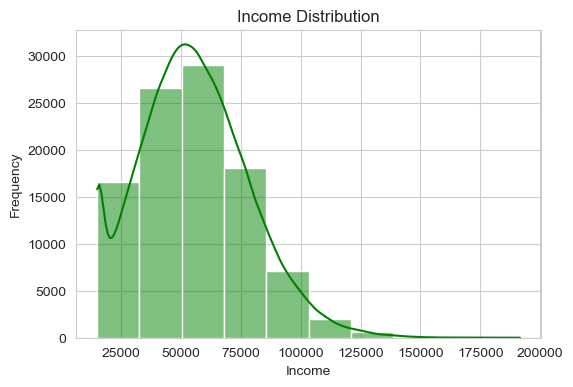

In [ ]:
# Income Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Income"], bins=10, kde=True, color="green")
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/1726537035.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




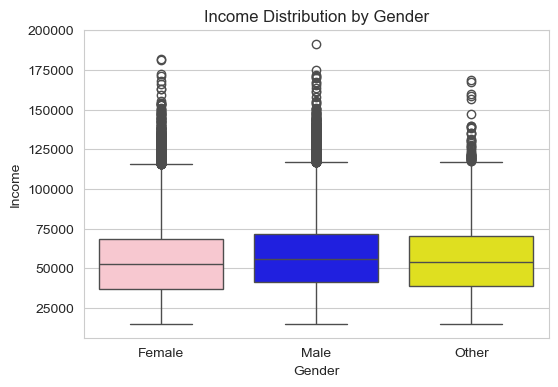

In [ ]:
# Compare income distribution between male and female
plt.figure(figsize=(6,4))
sns.boxplot(x="Gender", y="Income", data=demo, palette={"Male": "blue", "Female": "pink", "Other":"yellow"})
plt.title("Income Distribution by Gender")
plt.show()

## Location

In [ ]:
# Most common customer locations
top_locations = demo["Location"].value_counts().head(5)
top_locations

Location
New Michael      105
Port Michael      87
South Michael     85
North Michael     85
West Michael      84
Name: count, dtype: int64

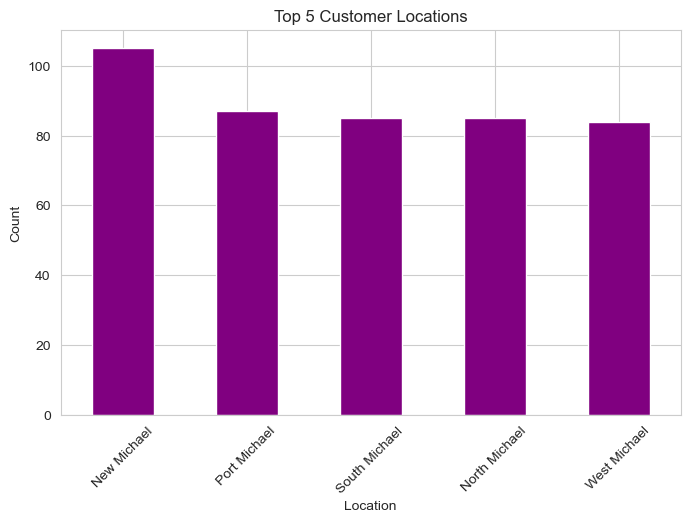

In [ ]:
plt.figure(figsize=(8,5))
top_locations.plot(kind="bar", color="purple")
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Top 5 Customer Locations")
plt.xticks(rotation=45)
plt.show()

## Clustering

Based on full demo data (w/o mapping to sub data's segmentation), the most determinant factor on clustering is `income`. No big difference across various genders and/or ages.

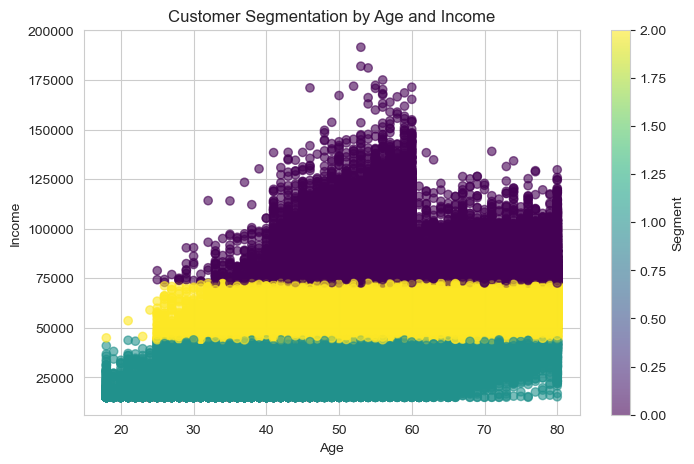

In [ ]:
from sklearn.cluster import KMeans

# Select numerical features for clustering
X = demo[["Age", "Income"]]

# Apply K-Means with 3 clusters (Low, Mid, High)
kmeans = KMeans(n_clusters=3, random_state=42)
demo["Segment"] = kmeans.fit_predict(X)

# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Customer Segmentation by Age and Income")
plt.colorbar(label="Segment")
plt.show()


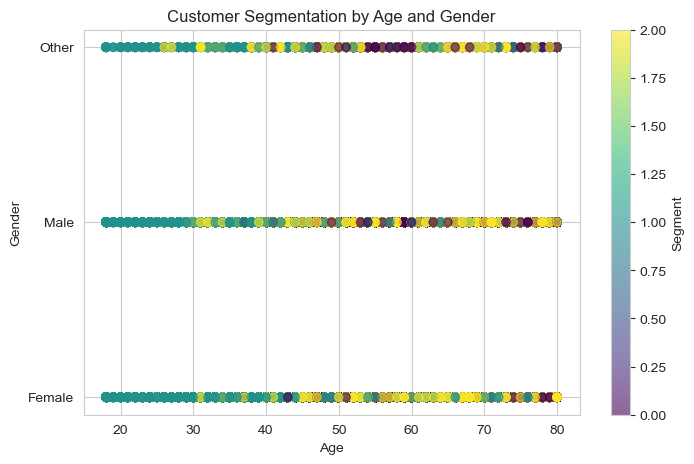

In [ ]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Gender"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Gender")
plt.title("Customer Segmentation by Age and Gender")
plt.colorbar(label="Segment")
plt.show()

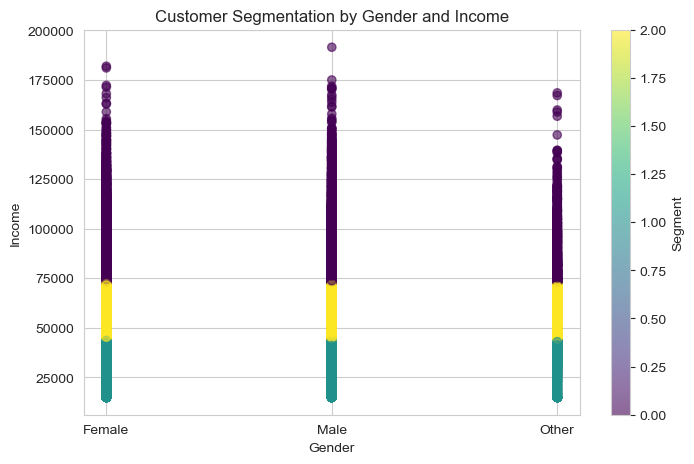

In [ ]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Gender"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Gender")
plt.ylabel("Income")
plt.title("Customer Segmentation by Gender and Income")
plt.colorbar(label="Segment")
plt.show()

# Churn Analysis
## Multi-subscriber
create a new feature named ‘MultipleSubscriber’ and use one hot encoding to code capstone ids who subscribed to more than one brand. 
- multi brand user: 10% 
- multi freq user: 4% 
- multi brand + freq user: 22% 

In [20]:
sub_prep = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_preprocessed.csv')

In [22]:
# Identify users subscribing to multiple brands
multi_brand_users = sub_prep.groupby('Capstone_id')['BRAND'].nunique() > 1

# # Identify users who subscribed multiple times within a brand
# multi_frequency_users = sub_prep.groupby('Capstone_id')['FREQUENCY'].max() > 1

# Combine both conditions
sub_prep['MultipleSubscriber'] = sub_prep['Capstone_id'].map(
    lambda x: int(multi_brand_users.get(x, True))
)
sub_prep

,Unnamed: 0,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,TERM_NUM,REVENUE_RECALC,REVENUE_RECALC_Cluster,RECENCY_Cluster,FREQUENCY_Cluster,Score,Segment,MultipleSubscriber
0,0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501,1.0,11.99,0,0,2,0.4,Low-Value,1
1,1,61,2024-09-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,PJW3033219,3.0,35.97,0,0,2,0.4,Low-Value,0
2,2,7,2024-11-01,2024-11-08,1,monthly,7.99,95.88,0,PULSE,DPZ5855080,1.0,7.99,0,0,2,0.4,Low-Value,0
3,3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372,2.0,23.98,0,0,2,0.4,Low-Value,0
4,4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438,5.0,59.95,1,1,2,1.2,Mid-Value,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111663,111663,47,2024-04-01,2024-05-18,1,monthly,9.99,119.88,0,RETROREEL,GVL0937699,2.0,19.98,0,0,2,0.4,Low-Value,1
111664,111664,14,2024-10-18,2024-11-01,1,annual,74.88,74.88,0,RETROREEL,WIK6007190,1.0,74.88,1,0,2,0.9,Mid-Value,0
111665,111665,144,2024-04-10,2024-09-01,1,monthly,8.99,107.88,0,CINEQUEST,UVO5445609,5.0,44.95,1,1,2,1.2,Mid-Value,0
111666,111666,186,2024-05-17,2024-11-19,1,annual,62.99,62.99,0,CINEQUEST,IRK2385888,1.0,62.99,1,1,2,1.2,Mid-Value,0


Option 1: ignore multi-subscriber

In [23]:
sub_single = sub_prep[sub_prep['MultipleSubscriber']==0]
sub_multi = sub_prep[sub_prep['MultipleSubscriber']==1]
print(f'Single Subscriber: {sub_single.Capstone_id.nunique()} ({round(100*sub_single.Capstone_id.nunique()/sub_prep.Capstone_id.nunique(), 2)} %),\
     Multi Subscriber: {sub_multi.Capstone_id.nunique()} ({round(100*sub_multi.Capstone_id.nunique()/sub_prep.Capstone_id.nunique(), 2)} %)')

Single Subscriber: 89597 (89.6 %),     Multi Subscriber: 10403 (10.4 %)


Option 2: calculate recency of multi subs using the max recency, and sum frequency and monetary values

In [24]:
sub_multi_rfm = sub_multi.groupby('Capstone_id', as_index=False).agg({'RECENCY':'max', 'FREQUENCY':'sum', 'REVENUE_RECALC':'sum'})
sub_multi_rfm

,Capstone_id,RECENCY,FREQUENCY,REVENUE_RECALC
0,AAC5316297,61,3,149.82
1,AAE3424858,242,2,111.87
2,AAG7917521,106,2,67.92
3,AAI0419100,32,2,104.86
4,AAI2036587,274,4,215.76
...,...,...,...,...
10398,ZZT8738866,274,2,161.76
10399,ZZU8592168,274,3,309.70
10400,ZZX5727451,253,2,169.87
10401,ZZY8936381,274,2,171.84


In [28]:
sub_prep[sub_prep.Capstone_id=='AAI2036587']

,Unnamed: 0,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,TERM_NUM,REVENUE_RECALC,REVENUE_RECALC_Cluster,RECENCY_Cluster,FREQUENCY_Cluster,Score,Segment,MultipleSubscriber
58533,58533,92,2024-08-01,2024-11-01,1,monthly,8.99,107.88,0,CHILLSTREAM,AAI2036587,4.0,35.96,0,1,2,0.7,Mid-Value,1
79959,79959,274,2024-02-01,2024-11-01,2,monthly,9.99,119.88,1,RETROREEL,AAI2036587,10.0,99.90,2,2,1,1.8,High-Value,1
110519,110519,274,2024-02-01,2024-11-01,1,monthly,7.99,95.88,0,PULSE,AAI2036587,10.0,79.90,2,2,2,2.0,High-Value,1


Option 3: In order to address cases where individuals are present in multiple brands,
we can create arrays capturing brand level information and roll it up to a global LTV
model. Brand level churn and LTV can be modeled/calculated first and this can be
fed into the global model. The alternative is to perform an aggregation (such as sum)
of brand level metrics, such as frequency and monetary value (see option 2. above),
but this will result in manipulation/distortion of our row level data, while the first
method retains this information at the unique id level.

## Train-Val-Test split
- training: 1/1 - 6/30
    - 1 Churned if sub end is in first 6, and 0 if sub end is not in first 6
- validation: 7/1 - 9/30
    - 1 Churn if sub end in July 1 to Sep. 30, and 0 if sub end is greater in Sep 30 then not churned
- test: 10/1 - 11/1
    - 1 Churn if sub end in Oct 1 to Nov 1 of 2024, 0 if greater in Nov then not churned

In [29]:
train_beg, train_end = '2024-01-01', '2024-06-30'
val_beg, val_end = '2024-07-01', '2024-09-30'
test_beg, test_end = '2024-10-01', '2024-11-01'

In [35]:
sub_train = sub_prep[(sub_prep['SUB_START']>=train_beg) & (sub_prep['SUB_START']<=train_end)]
sub_val = sub_prep[(sub_prep['SUB_START']>=val_beg) & (sub_prep['SUB_START']<=val_end)]
sub_test = sub_prep[(sub_prep['SUB_START']>=test_beg) & (sub_prep['SUB_START']<=test_end)]

In [46]:
sub_train['Churned'] = ((sub_train['SUB_END']>=train_beg) & (sub_train['SUB_END']<=train_end)).astype(int)
sub_val['Churned'] = ((sub_val['SUB_END']>=val_beg) & (sub_val['SUB_END']<=val_end)).astype(int)
sub_test['Churned'] = ((sub_test['SUB_END']>=test_beg) & (sub_test['SUB_END']<=test_end)).astype(int)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [47]:
print(sub_train['Churned'].mean(), sub_val['Churned'].mean(), sub_test['Churned'].mean())

0.5037939565843004 0.20396943719716734 0.7941807044410414


In [48]:
sub_train[['SUB_START', 'SUB_END', 'Churned']]

,SUB_START,SUB_END,Churned
0,2024-02-27,2024-03-05,1
3,2024-02-01,2024-03-04,1
4,2024-05-17,2024-10-01,0
5,2024-02-01,2024-03-04,1
6,2024-02-01,2024-05-17,1
...,...,...,...
111662,2024-02-01,2024-11-01,0
111663,2024-04-01,2024-05-18,1
111665,2024-04-10,2024-09-01,0
111666,2024-05-17,2024-11-19,0


In [49]:
sub_val[['SUB_START', 'SUB_END', 'Churned']]

,SUB_START,SUB_END,Churned
1,2024-09-01,2024-11-01,0
20,2024-09-01,2024-11-01,0
24,2024-08-30,2024-09-01,1
28,2024-09-01,2024-10-01,0
36,2024-07-01,2024-10-01,0
...,...,...,...
111585,2024-07-01,2024-11-01,0
111586,2024-07-08,2024-11-01,0
111615,2024-07-01,2024-11-01,0
111623,2024-09-16,2024-11-01,0


In [50]:
sub_test[['SUB_START', 'SUB_END', 'Churned']]

,SUB_START,SUB_END,Churned
2,2024-11-01,2024-11-08,0
31,2024-10-06,2024-11-01,1
52,2024-10-01,2024-11-01,1
62,2024-10-01,2024-11-01,1
69,2024-10-18,2024-11-01,1
...,...,...,...
111460,2024-10-06,2024-10-13,1
111508,2024-10-27,2024-11-01,1
111512,2024-10-02,2024-11-01,1
111526,2024-10-01,2024-11-01,1
